In [40]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from skmultilearn.problem_transform import LabelPowerset
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight
import neuralcoref 



In [41]:
from sklearn.model_selection import train_test_split
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="C:\\Users\\SHAILENDRA\\glove.42B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

import spacy
nlp = spacy.load('C:\\Users\\SHAILENDRA\\Anaconda3\\envs\\tf_gpu\\Lib\\site-packages\\en_core_web_md\\en_core_web_md-2.1.0') 


In [42]:
a=pd.read_csv('highland.csv')
#b=pd.read_csv('thikana.csv')
c=pd.read_csv('your-ale-house.csv')
d=pd.read_csv('rabits-burrow1.csv')
#e=pd.read_csv('terttulia-bistro.csv')
#f=pd.read_csv('linkin-barrel.csv')
#g=pd.read_csv('azzurro.csv')

In [43]:
a.shape

(394, 4)

In [44]:
final=pd.concat([c,d,a])

In [45]:
#final.drop('Unnamed: 0',axis=1,inplace=True)
final.shape

(620, 4)

In [46]:
final.groupby('res_name').agg('count')

,rating,comment,label
res_name,,,
highland,394,394,394
mr-rabbits-bar-burrow,113,113,113
your-ale-house,113,113,113


In [47]:
import re
a="Ambiance: 3/5 Food: 3/5 Service: 3/5 "
b='Service- (5/5) Taste - 5/5 Ambience-4/5'
c=' Ambience on terrace 4/5 lighting can be better on terrace Starters 5/5 we had chilli chicken, kebabs, veg Manchurian, and paneer pakodas. It was yumm♥️ Dinner 3.5/5'
d='I would rate it 1.5 Alcohol choices 4 Pricing 3 Ambiance 3.5 Staff courtesy 3.5 Over all rating 3 '
e='if we order drinks after 8 pm then we get 10 percent discount. He only comes to our table at 5 mins to 8 to inform the same. '
f='Quality n Quantity- They have Diverse Menu which is lots to choose from as all are tasty,delicious and of good quality of International level!!!. -------------------------- Rating for Pricing-4.8/5* Rating for hospitality-5/5* its a must visit Here.   '
g='great variety of fresh craft beers served by 2nd Pint Brew Co. This brewery serves some of the best craft beers in town. The manager/owner, also helps you choose appetizers which go well with these beers. Their bartender is a master at cocktails. I’ve occasionally had their Sangria, their LIIT and mojito and he’s never gone wrong! Great job Anand! Rating: 5/5. Overall, one of the finest places to visit in Pune on any day of the week. It is difficult to find places where good food is served with good alcohol, and this place delivers both. Good going guys! I’m definitely a regular! Cheers'
li=[a,b,c,d,e,f,g]

def clean_review(i):
    clean=re.sub('\(([a-zA-Z]|\W|[0-9][0-9]+)+\)','',i)
    clean=re.sub(':(\s|)[0-2](\.[0-5]|)\/5'," is bad.",clean)
    clean=re.sub(':(\s|)[3-5](\.[0-5]|)\/5'," is good.",clean)
    clean=re.sub('(\s|:|-)[0-2](\.[0-5]|)\/5'," is bad.",clean)
    clean=re.sub('(\s|:|-)[3-5](\.[0-5]|)\/5'," is good.",clean)
    clean=re.sub('(\s|:|-)[0-3](\.[0])\/5'," is bad.",clean)
    clean=re.sub('(\s|:|-)[3-5](\.[0-9])\/5'," is good.",clean)
    clean=re.sub('(\s|:|-)[0-3](\.[0-4]|\s|)'," is bad.",clean)
    clean=re.sub('(\s|:|-)[3-5](\.[5]|\s|)'," is good.",clean)
    clean=re.sub('(#|@)[a-zA-Z0-9]+(_|-|[a-zA-Z0-9]+)',"",clean) #remove all the tags relating to # or @ 
    clean=re.sub('\(',' ',clean)
    
    clean=re.sub('\)',' ',clean)
    clean=re.sub('\.(\.)+','.',clean)
    clean=re.sub('\!(\!)+','!',clean)
    clean=re.sub('oo(o)+','o',clean)
    #clean=re.sub(':',' is',clean)
    
    clean=re.sub('[0-9](\.|\))+','',clean)
    clean=re.sub('(d|D)(j|J)','dj',clean)
    clean=re.sub('-',' is ',clean)
    clean=re.sub('\*+','',clean)  
    clean=re.sub('\,(,)+',',',clean)  
    clean=re.sub('\s(n|N)\s',' and ',clean)
    clean=re.sub('("|")','',clean)
    #clean=re.sub('\.',' . ',clean)#beacuse some sentences create trouble while parsing 
    clean=re.sub('[zZ](z|Z)+','z',clean)
    clean=re.sub('[:;)}]+([OPop]|)\s',' ',clean)#removes smileys like :)
    clean=re.sub('[0-9](:|\))',',',clean)# this removes 5) and 5.
    
    #clean=re.sub('[0-9](nd|rd|th)','',clean) to remove 2nd,3rd
    clean=clean.replace('ambiance','ambience').replace('Ambiance','Ambience').replace('ambeience','Ambience').replace('₹','rupees').replace('Rs.',' rupees ').replace('mins','minutes')\
          .replace("’m",' am').replace("n’t",' not').replace("'s",' is').replace("'m",' am').replace("n't",' not').replace("’s",' is').replace("dnt",' dont').replace("wl",' will').replace("its",'it is')\
          .replace("Zgold",'zomato gold').replace("Zomato gold",'zomato gold').replace("Zomato Gold",'zomato gold').replace("handson",'handsome').replace("appricate",'appreciate')\
          .replace('okayish','okay').replace('okish','okay').replace('okeish','okay').replace('A/C','ac').replace('AC','ac').replace('a/c','ac').replace('dinnwr','dinner').replace('cityyy','city').replace('captain','waiter').replace('Captain','waiter')\
          .replace('!','.').replace('chill','enjoy').replace('legen.wait for it.dary','legendary').replace('Piza','pizza').replace('piza','pizza')
    clean=re.sub(r'[^\x00-\x7F]', '', clean)#removes non ascii hearts and stars keep at last

    return(clean.strip())
#re.sub('!(\s)','',c)

In [49]:
final.comment=final.comment.apply(lambda x:clean_review(x))

In [52]:
l=[]
amb=['amience','ambienc','ambiences','ambiemce']
alc=['drink','drinks']
service=['serivce','staff']
for i in final.label:
    for j in i.split(','):
        if(j  in alc):
            j='alcohol'
        if(j.strip() in service):
            #print(j)
            j='service'
        if(j.strip()in amb):
            j='ambience'
        if(j.strip()== 'muisc'):
            j='music'   
        
        l.append(j.strip())

In [53]:
from sklearn.model_selection import train_test_split
y=final.label
#c.drop(['label'],inplace=True,axis=1)
x_train, x_test, y_train, y_test=train_test_split(final,y,test_size=0.3 ,random_state=42)


In [54]:
x_test.shape

(186, 4)

In [55]:

v=pd.DataFrame(l)
label_dict=pd.value_counts(v.iloc[:,0]).to_dict()

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=label_dict.keys() ,lowercase=False, binary=True)
categories_one_hot_train = vectorizer.fit_transform(x_train.label.values)
categories_one_hot_test = vectorizer.transform(x_test.label.values)
x_tr=pd.DataFrame(categories_one_hot_train.toarray(),columns=vectorizer.get_feature_names())
x_te=pd.DataFrame(categories_one_hot_test.toarray(),columns=vectorizer.get_feature_names())
x_train.reset_index(inplace=True)
x_test.reset_index(inplace=True)
final_x_tr=pd.concat([x_train,x_tr],axis=1)
final_x_te=pd.concat([x_test,x_te],axis=1)
final_x_tr.drop(['index','label'],axis=1,inplace=True)
final_x_te.drop(['index','label'],axis=1,inplace=True)
final_x_tr.rating=final_x_tr.rating.apply(lambda x:int(x.split(" ")[1].split('.')[0]))
final_x_te.rating=final_x_te.rating.apply(lambda x:int(x.split(" ")[1].split('.')[0]))


In [57]:
final_x_tr.comment=final_x_tr.comment.apply(lambda x:clean_review(x))
final_x_te.comment=final_x_te.comment.apply(lambda x:clean_review(x))

In [58]:
import nltk
sno = nltk.stem.SnowballStemmer('english')
stopwords= ['i', 'me', 'my','this', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
def l_class(review_list):    
    processed=[]
    for re in review_list:
        review=[]
        for i in re.split('.'):

            word=[]
            ii=i.split(" ")
            #print(ii)
            for j in ii:

                if(j !='' and j not in stopwords):
                    word.append(sno.stem(j.strip().lower()))
            #print(sent)
            sentence=" ".join(word)
            review.append(sentence)
        processed.append(('.'.join(review)))
    return processed

In [59]:
tr_list=l_class(final_x_tr.comment)
te_list=l_class(final_x_te.comment)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=300,min_df=3,ngram_range=(1,1))

text_tfidf_train = vectorizer.fit_transform(tr_list)

text_tfidf_test = vectorizer.transform(te_list)

In [61]:
text_tfidf_train.shape

(434, 300)

food_count
service_count
ambience_count
misc_count
alcohol_count
music_count
   food  service  ambience  misc  alcohol  music
0    67      187       199   230      268    301
1   367      247       235   204      166    133


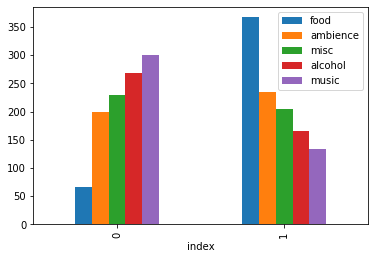

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
d=pd.DataFrame()
for i in ['food','service', 'ambience', 'misc','alcohol', 'music']:
    j=i+'_count'
    print(j)
    d[i]=final_x_tr.groupby(i,as_index=False)['rating'].agg('count').rename(columns={'rating':j})[j]
print(d)
d.reset_index(inplace=True)
#plt.rcParams["figure.figsize"] = (20,20)
d.plot(x='index',y=['food', 'ambience', 'misc','alcohol', 'music'],kind='bar')
#ax = d.plot(x='index', y="A", kind="bar")
#df.plot(x="index", y="B", kind="bar", ax=ax, color="C2")
#df.plot(x="X", y="C", kind="bar", ax=ax, color="C3")


food_count
service_count
ambience_count
misc_count
alcohol_count
music_count
   food  service  ambience  misc  alcohol  music
0    31       60        85    88      104    126
1   155      126       101    98       82     60


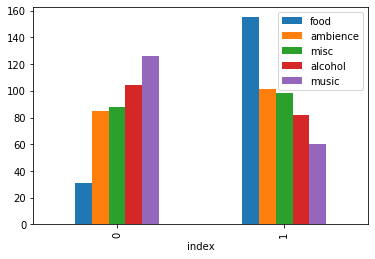

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
d=pd.DataFrame()
for i in ['food','service', 'ambience', 'misc','alcohol', 'music']:
    j=i+'_count'
    print(j)
    d[i]=final_x_te.groupby(i,as_index=False)['rating'].agg('count').rename(columns={'rating':j})[j]
print(d)
d.reset_index(inplace=True)
#plt.rcParams["figure.figsize"] = (20,20)
d.plot(x='index',y=['food', 'ambience', 'misc','alcohol', 'music'],kind='bar')
#ax = d.plot(x='index', y="A", kind="bar")
#df.plot(x="index", y="B", kind="bar", ax=ax, color="C2")
#df.plot(x="X", y="C", kind="bar", ax=ax, color="C3")


In [175]:
def meta_features(df):
    df['len_of_comment']=df.iloc[:,2].apply(lambda x:len(x))
    df['no_of_word_comment']=df.iloc[:,2].apply(lambda x:len(x.split(" ")))
    df['no_of_sent_comment']=df.iloc[:,2].apply(lambda x:len(x.split(".")))

meta_features(final_x_tr)
meta_features(final_x_te)




In [176]:
def cal(x):
    count=0
    for i in range(0,6):
        if(x[i]==1):
            count+=1
    return count
final_x_tr['no_of_labels']=final_x_tr.iloc[:,[3,4,5,6,7,8]].apply(lambda x:cal(x),axis=1)
final_x_te['no_of_labels']=final_x_te.iloc[:,[3,4,5,6,7,8]].apply(lambda x:cal(x),axis=1)
#final_x_tr.iloc[0:2,[3,4,5,6,7,8]].apply(lambda x:cal(x),axis=1)

In [182]:
#scaling all the numerical attributes helped in increasing the accuracy by 2 %
from sklearn.preprocessing import MinMaxScaler
s=MinMaxScaler()
final_x_tr.iloc[:,1]= s.fit_transform(final_x_tr.iloc[:,1].values.reshape(-1,1))
final_x_te.iloc[:,1]= s.transform(final_x_te.iloc[:,1].values.reshape(-1,1))

s=MinMaxScaler()
final_x_tr.iloc[:,9]= s.fit_transform(final_x_tr.iloc[:,9].values.reshape(-1,1))
final_x_te.iloc[:,9]= s.transform(final_x_te.iloc[:,9].values.reshape(-1,1))


s=MinMaxScaler()
final_x_tr.iloc[:,10]= s.fit_transform(final_x_tr.iloc[:,10].values.reshape(-1,1))
final_x_te.iloc[:,10]= s.transform(final_x_te.iloc[:,10].values.reshape(-1,1))


s=MinMaxScaler()
final_x_tr.iloc[:,11]= s.fit_transform(final_x_tr.iloc[:,11].values.reshape(-1,1))
final_x_te.iloc[:,11]= s.transform(final_x_te.iloc[:,11].values.reshape(-1,1))


s=MinMaxScaler()
final_x_tr.iloc[:,12]= s.fit_transform(final_x_tr.iloc[:,12].values.reshape(-1,1))
final_x_te.iloc[:,12]= s.transform(final_x_te.iloc[:,12].values.reshape(-1,1))



In [198]:
from scipy.sparse import hstack
x_tf_idf_tr_stacked=hstack([final_x_tr.iloc[:,[1,9,10,11,12]],text_tfidf_train])
x_tf_idf_te_stacked=hstack([final_x_te.iloc[:,[1,9,10,11,12]],text_tfidf_test])


In [69]:
class_names=['misc','food','service','ambience','alcohol','music']

In [72]:
pd.value_counts(x_te.service)

1    126
0     60
Name: service, dtype: int64

In [73]:
pd.value_counts(x_te.alcohol)

0    104
1     82
Name: alcohol, dtype: int64

In [74]:
pd.value_counts(x_te.ambience)

1    101
0     85
Name: ambience, dtype: int64

In [75]:
pd.value_counts(x_te.music)

0    126
1     60
Name: music, dtype: int64

In [76]:
pd.value_counts(x_te.food)

1    155
0     31
Name: food, dtype: int64

In [77]:
from sklearn.utils import class_weight
d={}
for i in class_names:
    print(i)
    class_weights = list(class_weight.compute_class_weight('balanced',
                                             x_tr[i].unique(),
                                             x_tr[i]))
    d[i]=class_weights

misc
food
service
ambience
alcohol
music


In [78]:
d

{'misc': [0.9434782608695652, 1.0637254901960784],
 'food': [0.5912806539509536, 3.2388059701492535],
 'service': [1.160427807486631, 0.8785425101214575],
 'ambience': [1.0904522613065326, 0.9234042553191489],
 'alcohol': [1.3072289156626506, 0.8097014925373134],
 'music': [0.7209302325581395, 1.631578947368421]}

In [79]:
li=[]
l=[]
amb=['amience','ambienc','ambiences','ambiemce']
alc=['drink','drinks']
service=['serivce','staff']
for i in x_train.label:
    temp=[]
    for j in i.split(','):
        if(j  in alc):
            j='alcohol'
        if(j.strip() in service):
            #print(j)
            j='service'
        if(j.strip()in amb):
            j='ambience'
        if(j.strip()== 'muisc'):
            j='music'   
        
        temp.append(j.strip())
    li.append(set(temp))
x_train['labell']=li

li=[]
l=[]
amb=['amience','ambienc','ambiences','ambiemce']
alc=['drink','drinks']
service=['serivce','staff']
for i in x_test.label:
    temp=[]
    for j in i.split(','):
        if(j  in alc):
            j='alcohol'
        if(j.strip() in service):
            #print(j)
            j='service'
        if(j.strip()in amb):
            j='ambience'
        if(j.strip()== 'muisc'):
            j='music'   
        
        temp.append(j.strip())
    li.append(set(temp))
x_test['labell']=li

c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_tr = mlb.fit_transform(x_train.labell)
y_te = mlb.transform(x_test.labell)

In [200]:

from skmultilearn.problem_transform import LabelPowerset
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import Pipeline
text_clf = Pipeline([('clf', LabelPowerset(LogisticRegression(C=10)))])
text_clf = text_clf.fit(x_tf_idf_tr_stacked, y_tr)
predicted = text_clf.predict(x_tf_idf_te_stacked)

# Calculate accuracy
np.mean(predicted.todense() == y_te)


c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\scipy\sparse\lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
c:\users\shailendra\anaconda3\envs\tf_gpu\lib\site-packages\scipy\sparse\lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warni

0.7231182795698925

In [201]:
df1=pd.DataFrame(predicted.todense()==y_te,columns=mlb.classes_)

In [202]:
df1.shape

(186, 6)

In [203]:
#df2=pd.DataFrame(predicted.todense()==np.ones([124,6]),columns=mlb.classes_)

df2=pd.DataFrame(predicted.todense()==np.ones([186,6]),columns=mlb.classes_) # when the data is divided into 0.3 test above for 0.2


In [204]:
#pd.merge(df1, df2, how='outer',indicator=True)
df3=pd.DataFrame()
df3['alcohol']=df1.alcohol & df2.alcohol
df3['ambience']=df1.ambience & df2.ambience
df3['food']=df1.food & df2.food
df3['misc']=df1.misc & df2.misc
df3['music']=df1.music & df2.music
df3['service']=df1.service & df2.service
#df3

In [205]:
def label(x):
    l=[]
    labels=mlb.classes_
    for i in range(0,len(x)):
        #print(i)
        if(x[i]==True):
            l.append(labels[i])
    return(l)
final_x_te['predicted_label']=df3.apply(lambda x:label(x),axis=1)

In [206]:
after_pred_te=pd.DataFrame({'res_name':final_x_te.res_name,'comment':final_x_te.comment, 'predicted':mlb.inverse_transform(predicted)})

In [88]:
test_reviews=after_pred_te.iloc[1:5,1]

In [97]:
from collections import Counter
def aspect_extraction(j):
    #print('**')
    sent=nlp(j)
    sent_dict={}
    noun_count=0
    aspect=['alcohol','novice', 'ambience', 'Food','food', 'misc', 'music', 'service','drinks','cocktails','moctails']
    pos=['yum','awesome','ample','amazing','great','good','epic','pleasant''helpful','nice','decent','better']
    neg=['bearable','disgusting','limited','bad','cheap']
    for token in sent:
        key=''
        value=''
        
        if(token.dep_=='nsubj' ):# modified as per 1 where if  acomp and advmod is in children of acomp then take advmod
            #print(token.text)    
            root=token
            key=token.text
            for k in root.children:
                if(k.dep_=='amod'):
                   # print(k.text)
                    #print('--!!!!--')
                    value=k.text
                    break;
            
            root=token.head
            
            if(token.pos_=='PROPN'):
                key='waiter'
                #print(key,token)
            else:
                key=token.text
           # if(token.head.dep_=='conj') commented due to 45 if un commenting check with 45 as well
           #   value=token.head.text
                   
                #print(token,token.dep_,token.head.text)
           # if(token.head.pos_=='VERB'and token.head.dep_=='ROOT'): #added after 41 makes a lot of noise for rest
           #     value=token.head.text
           #     print(key,value)
        
            for k in root.children:
                   # print(k,k.dep_,k.head)
                    
                if(k.dep_=='nsubj'): #added for 60-61
                    key=k.text
                    #print(key)
                if(k.dep_=='acomp' ):
                    root=k
                    value=k.text
                    #print(value)
                    for l in root.children:
                        if(l.dep_=='advmod'  ):
                            #print(key,l.text)
                            value= l.text+'.'+value
                            break;
                       # elif(l.pos_=='ADJ'): #example staff was friendly but slow
                            #print(key,l.text)
                            value= l.text
                            break;
                    
                

                elif(k.dep_=='conj'):
                    value=k.text
                    #print(value)
                        
                elif(k.dep_=='attr'):  #added for 60-61
                    value=k.text
                    #print(value)
                    
                elif(k.pos_=='ADV' and k.dep_=='neg'):# try repacing with numbers if good add +1 and bad then -.6
                    for i in k.head.children:
                        if(i.dep_=='acomp'or i.dep_=='amod'):
                            value=k.text+'.'+i.text
                    
                        
                if(key!='' and value !='' and value!=0 and key not in sent_dict.keys()):
                    sent_dict[key]=value 
                    #print(sent_dict)
                   # if(k.dep_=='amod'):
        
                
            
            #root=token.head#from here till line 72  also 56 to accomodate 93 example 
            
            #if(token.head.dep_=='prep'):
            #    print(root.head.text,root.head.dep_)
            #    if(root.head.dep_=='amod'):
            #        value=token.head.head.text
            #        print(value)
            
        elif((token.pos_=='NOUN' or token.pos_=='PROPN') and (key=='') and (value=='') ):
            root=token#searchin in its children
            #print(root)
            if(token.head.text in sent_dict.keys()):
                
                key=token.text
                value=sent_dict[token.head.text]
            elif(token.head.dep_=='amod'):#or token.head.pos_=='VERB'
                value=token.head.text
                key=token.text
                #print(key,value)
            elif(token.head.pos_=='VERB'):#or token.head.pos_=='VERB'
                flag=0
                for i in token.head.children:
                    if(i.pos_=='ADV'):
                        flag=1
                if(flag==1):
                    value=token.head.text
                    key=token.text
            elif((key=='') and (value=='') ):
                key=token.text
               # print(key)
                #if(found==0):
                amod_present=1
                prep_present=0
                for i in root.children:
                    if(i.dep_=='amod' or i.pos_=='ADJ'):# check for negation 95 write code for it
                        value=i.text
                        #found=1
                        amod_present=1
                        root=i
                        #print(key,value)


                        for j in root.children:
                            #print(j)
                            if(j.dep_=='npadvmod'): #example 109
                                value=j.text+'.'+root.text
                                #print(key,value)
                                break;
                    

                   # if(i.dep_=='prep'):
                   #     prep_present=1            


                    elif(i.dep_=='advmod' and value!=''):#yu can add sentiment and play with else
                        #print(value)
                        value=value+'.'+i.text
                        found=1
                    #print(key,value)
                    
            if((value=='')):
                root=token.head
                key=token.text
                value=''
                for i in root.children:
                    if(i.pos_=='ADJ' ):
                        #print(key,i.text)
                        if( value=='' or value==0 ):
                            value=i.text
                            
                        
                            #print(key,value)
                    if(i.dep_=='neg' and value!=0 and value!=''):
                        value=i.text+'.'+value
                        #print(key,value)

                
                
                
            if(key!='' and value !='' and value!=0 and key not in sent_dict.keys()):
                sent_dict[key]=value  
                

        elif(token.dep_=='dobj'):   #for example see first sentence
            #print('???')
            

            
            
            root=token
            value=token.text
           # print(root)    
            #print(token,token.dep_,token.head.text)
            for k in root.children:
                if(k.dep_=='amod'):
                    #print(k,k.dep_,k.head)
                    #value=token.head
                    value=k.text
                    key=k.head.text
                    #print(k.text)
                if(k.dep_=='prep'):
                    root =k
                    
                    for i in root.children:
                        if(i.dep_=='pobj'):
                            key=i.text 
                        
                        
                        
                   # print(key)     
                if(k.dep_=='nsubj'):
                    #print(k,k.dep_,k.head)
                    #value=token.head
                    key=k.text
                    value=root.text
                    #print(k.text)

                    #print('---*')
            if(key!='' and value !='' and value!=0):
                        sent_dict[key]=value   
                        #print(sent_dict)

               
        
        elif token.text.lower() in aspect+pos+neg and key=='' and value=='':
            #       sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
                
                #print(token)
                if (token.dep_ == "amod"):
                    #print(token)
                    sent_dict[token.head.text] =token.text
                    #print(token.head.text)
                    #here=0
                if (token.dep_ == "conj") and token.text not in sent_dict.keys() and token.head.text  in sent_dict.keys() :
                        #print(token not in sent_dict.keys())
                        #print(token.text)

                        sent_dict[token.text] = sent_dict[token.head.text]
                    #print(sent_dict[token.head.text])
                if(key!='' and value !='' and value!=0):
                    sent_dict[key]=value
                    

                
   
                    
    return(sent_dict)              
    print('--------------')   
    

In [227]:
def list_of_dict_to_dict(d):
    dd={}
    for i in d:
        for j in i.keys():
            dd[j]=i[j]
    return dd
def sent_calculation(x):
    for i in x.keys():
        print(i,x[i])
def similarity(aspect,li):
    temp=0
    c=0
    for i in li:
        try:
            temp+=glove_model.n_similarity([aspect],[i])
            c+=1
        except :
            #print('%s is not in the vocab'%(aspect))
            None
            
        
            
    if(c !=0):        
        return(temp/c)
    else:
        return 0

    

In [228]:
review="food and service are nice but music is bad."
count=0
final_list=[]
for i in after_pred_te.iloc[0:,1]:
    review=i
    d=[]
    print(count)
    ambience=['ambience','floor','decor','interior','view']
    music=['musician','dance','beats','dj','dn']
    staff=['staff','server','good','servers','service','hosts','team','owner','owners','management','waiters','raju','bartender','folks']
    not_staff=['we','it','one','they','were','restaurent','which','time','that','i']
    alc=['cocktails','mocktails','drinks','beer','towers']
    food=['food','quantity','kebab','dinner','dessert','gravy','tiramisu','starters','taste','chakna','biryani','flavours','pizza','cuisine','tandoori','wings','kebabs']
    pos=['yum','pretty','luscious','classic','stunning','big','star','kind','strong','pro','amiable','unique','sexy','interested','yummy','awesome','fast','unique','cheap','loved','ample','licking','smacking','high','soft','soulful','fab','amazing','something','tempting','love','smimilar','cozy','mannered','pleasing','great','observant','prompt','comfortable','worth','lively','good','best','epic','pleasant','clean','courteous','delicious','delecious','legendary','9/10','helpful','beautiful','nice','decent','tasty','quick','cozy','liked','perfect','lovely','polite','friendly']
    neg=['bearable','wrong','bland','arrogant','low','priced','oily','normal','disgusting','few','limited','bad','slow','better','overpriced','disappointment','slow','costly','ok','okay','local','okie','loud','hostile','pathetic','average','dull']

    advb=['really','so','too','equally','just','very','amazingly','made','much','extremely','eaqually','quite','pocket','enough']
    neg_advb=['not',]
    for x in review.split('.'):
    
        y=aspect_extraction(x)
        d.append(y)
        
    dd=list_of_dict_to_dict(d)# this is our dictionary for a single review
    amb_count=0
    alc_count=0
    food_count=0
    music_count=0
    staff_count=0
    
    for i in dd.keys():
        #print(i)
        if(i.lower() in food ):   
            temp=dd[i].split('.')# the value like awesome.made
            #print(temp)
            if(len(temp)>1):
                if(temp[0] in advb): 
                    if (temp[1] in pos):
                        food_count+=1.5
                    else:
                        food_count-=1.5
                        
                if(temp[1] in advb): 
                    if (temp[0] in pos):
                        food_count+=1.5
                    else:
                        food_count-=1.5
                elif(temp[0] in neg_advb):
                    if (temp[1] in neg):
                        food_count+=1.5
                    else:
                        food_count-=1.5
                        #print(i,food_count)
                
                        
                    

            else:
                #print(i,dd[i].lower())
                if(dd[i].lower() in pos):
                    food_count+=1
                    #print('**')
                if(dd[i].lower() in neg):
                    food_count-=1
                    #print(dd[i],i,food_count)
            #print(i,food_count)
        elif(i.lower() in alc):
            temp=dd[i].split('.')# the value like awesome.made
            if(len(temp)>1):
                if(temp[0] in advb): 
                    if (temp[1] in pos):
                        alc_count+=1.5
                    else:
                        alc_count-=1.5

                if(temp[1] in advb): 
                    if (temp[0] in pos):
                        alc_count+=1.5
                    else:
                        alc_count-=1.5
                elif(temp[0] in neg_advb):
                    if (temp[1] in neg):
                        alc_count+=1.5
                    else:
                        alc_count-=1.5
                    
            else:
                #print(dd[i])
                if(dd[i].lower() in pos):
                    alc_count+=1
                   
                if(dd[i].lower() in neg):
                    alc_count-=1
            #print(i,alc_count)
        elif(i.lower() in staff):
            #print("here is %s"%i)
            temp=dd[i].split('.')# the value like awesome.made
            if(len(temp)>1):
                if(temp[0] in advb): 
                    if (temp[1] in pos):
                        staff_count+=1.5
                    else:
                        staff_count-=1.5

                if(temp[1] in advb): 
                    if (temp[0] in pos):
                        staff_count+=1.5
                    else:
                        staff_count-=1.5
                elif(temp[0] in neg_advb):
                    if (temp[1] in neg):
                        staff_count+=1.5
                    else:
                        staff_count-=1.5
                #print(i,dd[i],staff_count)
                    
            else:
                
                if(dd[i].lower() in pos):
                    staff_count+=1
                   
                if(dd[i].lower() in neg):
                    staff_count-=1
                #print(i,dd[i],staff_count)
        elif(i.lower() in music):
            #print("here is %s"%i)
            temp=dd[i].split('.')# the value like awesome.made
            if(len(temp)>1):
                if(temp[0] in advb): 
                    if (temp[1] in pos):
                        music_count+=1.5
                    else:
                        music_count-=1.5

                if(temp[1] in advb): 
                    if (temp[0] in pos):
                        music_count+=1.5
                    else:
                        music_count-=1.5
                elif(temp[0] in neg_advb):
                    if (temp[1] in neg):
                        music_count+=1.5
                    else:
                        music_count-=1.5
                    
            else:
                
                if(dd[i].lower() in pos):
                    music_count+=1
                   
                if(dd[i].lower() in neg):
                    music_count-=1
                    
        elif(i.lower() in ambience):
            #print("here is %s"%i)
            temp=dd[i].split('.')# the value like awesome.made
            if(len(temp)>1):
                if(temp[0] in advb): 
                    if (temp[1] in pos):
                        amb_count+=1.5
                    else:
                        amb_count-=1.5

                if(temp[1] in advb): 
                    if (temp[0] in pos):
                        amb_count+=1.5
                    else:
                        amb_count-=1.5
                elif(temp[0] in neg_advb):
                    if (temp[1] in neg):
                        amb_count+=1.5
                    else:
                        amb_count-=1.5
                    
            else:
                
                if(dd[i].lower() in pos):
                    amb_count+=1
                   
                if(dd[i].lower() in neg):
                    amb_count-=1
                    

        
        else:      
            similarity_score=similarity(i.lower(),food)
            similarity_score=round(similarity_score,2)
            similarity_score_alc=similarity(i.lower(),alc)
            similarity_score_alc=round(similarity_score_alc,2)
            similarity_score_staff=similarity(i.lower(),staff)
            similarity_score_staff=round(similarity_score_staff,2)
            similarity_score_music=similarity(i.lower(),music)
            similarity_score_music=round(similarity_score_music,2)
            similarity_score_amb=similarity(i.lower(),ambience)
            similarity_score_amb=round(similarity_score_amb,2)
            print(i.lower(),similarity_score,similarity_score_alc,similarity_score_staff,similarity_score_music,similarity_score_amb)
            staff_flag=0
            music_flag=0
            food_flag=0
            alc_flag=0
            amb_flag=0
            
            flag_list=[similarity_score,similarity_score_alc,similarity_score_staff,similarity_score_music]
            maxi=max(flag_list)
            
            if(flag_list[0]==maxi):
                food_flag=1
            elif(flag_list[1]==maxi):
                alc_flag=1
            elif(flag_list[2]==maxi):
                staff_flag=1
            elif(flag_list[3]==maxi):
                music_flag=1
            elif(flag_list[4]==maxi):
                amb_flag=1
                
            #print("the flag seleceted for %s is %s and maxi is %s"%(i,music_flag,maxi)) 
                
        
            
            if(food_flag==1):
                
                temp=dd[i].split('.')# the value like awesome.made
            
                if(len(temp)>1 and  similarity_score>0.31):

                    if(temp[0] in advb): 
                        if (temp[1] in pos):
                            food_count+=1.5
                            
                        else:
                            food_count-=1.5
                            
                        
                    if(temp[1] in advb): 
                        if (temp[0] in pos):
                            food_count+=1.5
                        else:
                            food_count-=1.5
                    elif(temp[0] in neg_advb):
                        if (temp[1] in neg):
                            food_count+=1.5
                        else:
                            food_count-=1.5
                    #print(i,dd[i],food_count)   

                elif(similarity_score>0.31 and dd[i].lower() in pos+neg):
                    #print(i)
                    
                    if(dd[i].lower() in pos):
                        food_count+=1
                        
                    elif(dd[i].lower() in neg):
                        food_count-=1
                    #print(i,dd[i],food_count)
                        
                        
            if(alc_flag==1):
                
                
                temp=dd[i].split('.')# the value like awesome.made
                if(len(temp)>1 and  similarity_score_alc>0.35):
                    

                    if(temp[0] in advb): 
                        if (temp[1] in pos):
                            alc_count+=1.5
                        else:
                            alc_count-=1.5
                        
                    if(temp[1] in advb): 
                        if (temp[0] in pos):
                            alc_count+=1.5
                        else:
                            alc_count-=1.5
                    elif(temp[0] in neg_advb):
                        if (temp[1] in neg):
                            alc_count+=1.5
                        else:
                            alc_count-=1.5
                    
                elif(similarity_score_alc>0.35 and dd[i].lower() in pos+neg):
                    #print(dd[i],i.lower(),similarity_score)
                    #print("%s is here"%i)
                    if(dd[i].lower() in pos):
                        alc_count+=1
                    if(dd[i].lower() in neg):
                        alc_count-=1
                #print(i,dd[i],alc_count)  

            elif(staff_flag==1):                
                temp=dd[i].split('.')# the value like awesome.made
                
                #print(temp)
                if(len(temp)>1 and  similarity_score_staff>0.40 and i.lower() not in not_staff):
                    

                    if(temp[0] in advb): 
                        if (temp[1] in pos):
                            staff_count+=1.5
                        else:
                            staff_count-=1.5
                        
                    if(temp[1] in advb): 
                        if (temp[0] in pos):
                            staff_count+=1.5
                        else:
                            staff_count-=1.5
                    elif(temp[0] in neg_advb):
                        if (temp[1] in neg):
                            staff_count+=1.5
                        else:
                            staff_count-=1.5
                       

                elif(similarity_score_staff>0.40 and dd[i].lower() in pos+neg and i.lower() not in not_staff):
                    #print(dd[i],i.lower(),similarity_score_staff,staff_count)
                    
                    if(dd[i].lower() in pos):
                        staff_count+=1
                    if(dd[i].lower() in neg):
                        staff_count-=1
                    
                #print(i,dd[i],staff_count)  
            elif(music_flag==1):                
                temp=dd[i].split('.')# the value like awesome.made
                #print(len(temp))
                #print(temp)
                if(len(temp)>1 and  similarity_score_music>0.45):
                    

                    if(temp[0] in advb): 
                        #print(temp[0])
                        if (temp[1] in pos):
                            music_count+=1.5
                        else:
                            music_count-=1.5
                        
                    if(temp[1] in advb): 
                        if (temp[0] in pos):
                            music_count+=1.5
                        else:
                            music_count-=1.5
                    elif(temp[0] in neg_advb):
                        if (temp[1] in neg):
                            music_count+=1.5
                        else:
                            music_count-=1.5
                       

                elif(similarity_score_music>0.45 and dd[i].lower() in pos+neg):
                    
                    #print(dd[i],i.lower(),similarity_score)
                    
                    if(dd[i].lower() in pos):
                        music_count+=1
                    if(dd[i].lower() in neg):
                        music_count-=1
                    
                #print(i,dd[i],music_count) 
            elif(amb_flag==1):                
                temp=dd[i].split('.')# the value like awesome.made
                #print(len(temp))
                #print(temp)
                if(len(temp)>1 and  similarity_score_music>0.45):
                    

                    if(temp[0] in advb): 
                        #print(temp[0])
                        if (temp[1] in pos):
                            amb_count+=1.5
                        else:
                            amb_count-=1.5
                        
                    if(temp[1] in advb): 
                        if (temp[0] in pos):
                            amb_count+=1.5
                        else:
                            amb_count-=1.5
                    elif(temp[0] in neg_advb):
                        if (temp[1] in neg):
                            amb_count+=1.5
                        else:
                            amb_count-=1.5
                       

                elif(similarity_score_amb>0.45 and dd[i].lower() in pos+neg):
                    
                    #print(dd[i],i.lower(),similarity_score)
                    
                    if(dd[i].lower() in pos):
                        amb_count+=1
                    if(dd[i].lower() in neg):
                        amb_count-=1
                    
                #print(i,dd[i],amb_count) 
   
                    
            
            
            
        
    
    
    #print(dd)
    #print("the food count is :%f"%(food_count))
    #print("the alcohol count is :%f"%(alc_count))
    #print("the staff count is :%f"%(staff_count))
    #print("the music count is :%f"%(music_count))
    #print("the ambience count is :%f"%(amb_count))
    
    count+=1
    record=(food_count,alc_count,staff_count,music_count,amb_count)
    final_list.append(record)
    #sent_calculation(y)

0
rahagdale 0 0 0 0 0
waiter 0.27 0.26 0.3 0.13 0.19
it 0.28 0.26 0.43 0.34 0.39
time 0.25 0.24 0.41 0.31 0.36
1
veg 0.34 0.21 0.13 0.06 0.15
lit 0.15 0.23 0.2 0.18 0.33
minutes 0.24 0.22 0.31 0.24 0.28
2
corn 0.28 0.21 0.17 0.15 0.19
restaurant 0.39 0.36 0.37 0.22 0.39
disappointment 0.15 0.09 0.22 0.13 0.15
place 0.3 0.27 0.4 0.3 0.43
3
time 0.25 0.24 0.41 0.31 0.36
manager 0.13 0.15 0.43 0.23 0.25
host 0.19 0.23 0.42 0.3 0.25
it 0.28 0.26 0.43 0.34 0.39
4
lighting 0.14 0.19 0.21 0.21 0.45
it 0.28 0.26 0.43 0.34 0.39
desserts 0.43 0.4 0.18 0.14 0.22
brownie 0.25 0.16 0.11 0.1 0.09
place 0.3 0.27 0.4 0.3 0.43
5
street 0.17 0.23 0.27 0.28 0.35
seating 0.17 0.23 0.23 0.12 0.42
area 0.2 0.23 0.36 0.26 0.44
crowd 0.19 0.26 0.32 0.3 0.29
menu 0.36 0.3 0.3 0.2 0.33
host 0.19 0.23 0.42 0.3 0.25
visit 0.22 0.22 0.35 0.25 0.35
6
place 0.3 0.27 0.4 0.3 0.43
roof 0.15 0.2 0.24 0.17 0.4
thing 0.26 0.24 0.41 0.35 0.35
vibe 0.16 0.18 0.19 0.32 0.33
hour 0.24 0.27 0.34 0.28 0.29
rates 0.13 0.15 0.26

baner -0.05 -0.02 -0.05 -0.03 -0.02
entrance 0.15 0.21 0.24 0.17 0.4
bites 0.28 0.24 0.2 0.16 0.14
licking 0.13 0.11 0.12 0.12 0.14
pomfret 0.08 0.0 0.01 0.02 0.01
options 0.25 0.23 0.34 0.19 0.38
claypot 0.15 0.05 -0.06 -0.07 -0.04
81
place 0.3 0.27 0.4 0.3 0.43
music 0.2 0.25 0.31 0.5 0.34
vibes 0.11 0.16 0.13 0.28 0.18
conversation 0.2 0.23 0.32 0.25 0.29
82
it 0.28 0.26 0.43 0.34 0.39
place 0.3 0.27 0.4 0.3 0.43
tracks 0.14 0.15 0.25 0.37 0.28
which 0.27 0.28 0.42 0.32 0.4
rum 0.24 0.36 0.14 0.17 0.12
juices 0.29 0.35 0.13 0.09 0.13
essence 0.21 0.17 0.21 0.22 0.27
ones 0.28 0.27 0.38 0.28 0.33
83
place 0.3 0.27 0.4 0.3 0.43
rooftop 0.13 0.27 0.2 0.13 0.3
one 0.27 0.28 0.44 0.36 0.39
section 0.18 0.19 0.31 0.23 0.32
you 0.26 0.26 0.43 0.35 0.38
beat 0.2 0.19 0.3 0.43 0.24
part 0.23 0.21 0.38 0.33 0.36
i 0.27 0.26 0.41 0.35 0.34
options 0.25 0.23 0.34 0.19 0.38
this 0.24 0.21 0.38 0.3 0.38
it 0.28 0.26 0.43 0.34 0.39
84
place 0.3 0.27 0.4 0.3 0.43
rates 0.13 0.15 0.26 0.16 0.24
85
b

attitude 0.16 0.16 0.31 0.23 0.28
i 0.27 0.26 0.41 0.35 0.34
alice 0.13 0.16 0.19 0.24 0.2
burrow 0.03 -0.0 0.05 0.04 0.1
145
place 0.3 0.27 0.4 0.3 0.43
gold 0.16 0.16 0.26 0.25 0.28
146
order 0.26 0.21 0.35 0.24 0.33
dish 0.4 0.24 0.25 0.21 0.28
147
i 0.27 0.26 0.41 0.35 0.34
veggie 0.37 0.22 0.13 0.09 0.14
meals 0.4 0.36 0.28 0.15 0.26
britani -0.08 -0.08 -0.08 -0.09 -0.05
atmosphere 0.23 0.28 0.29 0.22 0.44
148
baner -0.05 -0.02 -0.05 -0.03 -0.02
road 0.19 0.17 0.27 0.22 0.29
this 0.24 0.21 0.38 0.3 0.38
hippie 0.1 0.11 0.08 0.2 0.17
tables 0.19 0.26 0.29 0.17 0.36
seating 0.17 0.23 0.23 0.12 0.42
place 0.3 0.27 0.4 0.3 0.43
option 0.22 0.19 0.34 0.21 0.35
speed 0.16 0.16 0.29 0.24 0.26
kalmi 0 0 0 0 0
corn 0.28 0.21 0.17 0.15 0.19
nanza -0.09 -0.09 -0.14 -0.15 -0.12
murgh 0.13 -0.02 -0.07 -0.08 -0.03
dish 0.4 0.24 0.25 0.21 0.28
drumsticks 0.17 0.05 -0.02 0.08 0.02
spices 0.37 0.25 0.12 0.11 0.19
yogurt 0.36 0.27 0.14 0.11 0.13
onions 0.33 0.16 0.12 0.08 0.09
chicken 0.46 0.27 0.2

In [118]:
#'wrong'.lower() in pos+neg
#after_pred_te.iloc[83:84,1].apply(lambda x :print(x))
final_df=pd.DataFrame(final_list,columns=['food','alcohol','service','music','ambience'])

In [119]:
after_pred_te.groupby(['res_name'])['res_name'].agg('count')

res_name
highland                 112
mr-rabbits-bar-burrow     35
your-ale-house            39
Name: res_name, dtype: int64

In [207]:
after_pred_te.head()

,res_name,comment,predicted
0,your-ale-house,Rahul Rahagdale is Mr. waiter helped us with...,"(ambience, food, misc, service)"
1,highland,Awesome drinks and Food . Great Veg Starters a...,"(alcohol, ambience, food, service)"
2,your-ale-house,The waiter tells you something else about the ...,"(alcohol, ambience, food, service)"
3,highland,One of the finest in Balewadi/Baner area. Grea...,"(alcohol, food, misc, service)"
4,your-ale-house,I visited this place for an office party. We r...,"(ambience, food, misc, service)"


In [208]:

l=[]
for i in range(0,after_pred_te.shape[0]):
    take=after_pred_te.iloc[i,2]
    search=final_df.iloc[i,].to_dict()
    take=list(take)
    #print(take)
    #print(search)
    d={}
    for j in take:
        if(j  in search.keys() and j!='misc'):
            d[j]=search[j]
    l.append(d)

        
        
        
        


In [209]:
temp_df=pd.DataFrame(l)
temp_df.fillna(999,inplace=True)

In [211]:
done=pd.concat([after_pred_te,temp_df],axis=1)

In [217]:
count=0
        
amb_count_high=112- pd.value_counts(done.iloc[done[done['res_name']=='highland'].index.tolist(),3])[999.0]    
amb_count_yah=35- pd.value_counts(done.iloc[done[done['res_name']=='your-ale-house'].index.tolist(),3])[999.0]  
amb_count_rab= 39-pd.value_counts(done.iloc[done[done['res_name']=='mr-rabbits-bar-burrow'].index.tolist(),3])[999.0]   

food_count_high=112- pd.value_counts(done.iloc[done[done['res_name']=='highland'].index.tolist(),4])[999.0]   
food_count_yah=35- pd.value_counts(done.iloc[done[done['res_name']=='your-ale-house'].index.tolist(),4])[999.0]  
food_count_rab= 39#-pd.value_counts(done.iloc[done[done['res_name']=='mr-rabbits-bar-burrow'].index.tolist(),4])[999.0]  

service_count_high=112- pd.value_counts(done.iloc[done[done['res_name']=='highland'].index.tolist(),5])[999.0]    
service_count_yah=35- pd.value_counts(done.iloc[done[done['res_name']=='your-ale-house'].index.tolist(),5])[999.0]   
service_count_rab= 39-pd.value_counts(done.iloc[done[done['res_name']=='mr-rabbits-bar-burrow'].index.tolist(),5])[999.0]  

alcohol_count_high=112- pd.value_counts(done.iloc[done[done['res_name']=='highland'].index.tolist(),6])[999.0]    
alcohol_count_yah=35- pd.value_counts(done.iloc[done[done['res_name']=='your-ale-house'].index.tolist(),6])[999.0]   
alcohol_count_rab= 39-pd.value_counts(done.iloc[done[done['res_name']=='mr-rabbits-bar-burrow'].index.tolist(),6])[999.0]  

music_count_high=112- pd.value_counts(done.iloc[done[done['res_name']=='highland'].index.tolist(),7])[999.0]    
music_count_yah=35- pd.value_counts(done.iloc[done[done['res_name']=='your-ale-house'].index.tolist(),7])[999.0]   
music_count_rab= 39-pd.value_counts(done.iloc[done[done['res_name']=='mr-rabbits-bar-burrow'].index.tolist(),7])[999.0]  




#done.iloc[[done],3].apply(lambda x:print(x) if(x!=999) else None)

In [218]:
done.replace(999.0,0,inplace=True)

In [ ]:
#food_count_high 107
#food_count_yah 33
#58.5/107 .5467
#29/33 .8787
#8.5/39

In [220]:
m=[music_count_high,music_count_rab,music_count_yah]
a=[alcohol_count_high,alcohol_count_rab,alcohol_count_yah]
amb=[amb_count_high,amb_count_rab,amb_count_yah]
f=[112,food_count_rab,food_count_yah]#manual
s=[service_count_high,service_count_rab,service_count_yah]

zzz=pd.DataFrame([a,amb,f,s,m]).T
zzz.columns=['alcohol','ambience','food','service','music']
zzz.index=['highland','mr-rabbits-bar-burrow','your-ale-house']
zzz

,alcohol,ambience,food,service,music
highland,42,69,112,69,19
mr-rabbits-bar-burrow,15,31,39,29,13
your-ale-house,14,30,33,27,5


In [221]:
zzz1=done.groupby(['res_name']).agg({'alcohol':'sum','ambience':'sum','food':'sum','service':'sum','music':'sum'})
zzz1

,alcohol,ambience,food,service,music
res_name,,,,,
highland,26.5,42.5,54.5,47.5,2.0
mr-rabbits-bar-burrow,0.5,10.0,8.5,23.0,2.5
your-ale-house,11.0,13.0,25.0,-2.0,2.0


In [222]:
#drawing radar plots to compare

In [223]:
zzz2=round(zzz1/zzz,2)
zzz2

,alcohol,ambience,food,service,music
res_name,,,,,
highland,0.63,0.62,0.49,0.69,0.11
mr-rabbits-bar-burrow,0.03,0.32,0.22,0.79,0.19
your-ale-house,0.79,0.43,0.76,-0.07,0.40


In [224]:
labels=np.array(['alcohol','ambience','food','service','music'])
stats=zzz2.iloc[2,:].values
stats1=zzz2.iloc[0,:].values


[0.63, 0.62, 0.49, 0.69, 0.11, 0.63]
[0.79, 0.43, 0.76, -0.07, 0.4, 0.79]


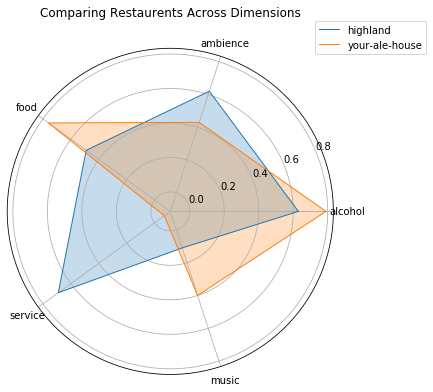

In [225]:
# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(car_model, color):
    values = zzz2.loc[car_model].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, label=car_model)
    ax.fill(angles, values, alpha=0.25)
    print(values)
add_to_radar('highland', '#1aaf6c')
add_to_radar('your-ale-house', '#429bf4')


# Add title.
ax.set_title('Comparing Restaurents Across Dimensions', y=1.08)
ax.set_thetagrids(np.degrees(angles), labels)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

